# Laboratory Work 5

---

### **Topic**: 
#### 🖥️ *Image processing with the OpenCV library and working with the bunch of digital image file*

---

### **Goal**:
#### 🎯 *Get knowledge and skills in digital image processing with OpenCV library and processing of a bunch digital images*

---

### **Progress of work**:

#### Task 1. Work with a bunch of files
#### 1) Create a function that takes the path to a folder on disk as an argument and returns a dataframe with the following information about the images in the folder:
- file name;
- color model;
- format;
- the number of channels in the image;
- file size in megabytes, rounded to two decimal places;
- image width;
- image height;
- full path to the file;
- image thumbnail

,name,color model,format,channels,size,width,height,full path,image
0,1.png,RGBA,PNG,4,0.70,967,601,/home/nikita/python-data-processing/lab5/images/1.png,
1,2.PNG,RGBA,PNG,4,0.47,716,450,/home/nikita/python-data-processing/lab5/images/2.PNG,
2,2.jpeg,RGB,JPEG,3,0.05,718,750,/home/nikita/python-data-processing/lab5/images/2.jpeg,
3,3.jpg,RGB,JPG,3,0.06,730,411,/home/nikita/python-data-processing/lab5/images/3.jpg,
4,4.jpg,RGB,JPG,3,0.03,700,394,/home/nikita/python-data-processing/lab5/images/4.jpg,
5,5.jpg,RGB,JPG,3,0.04,700,394,/home/nikita/python-data-processing/lab5/images/5.jpg,
6,6.jpg,RGB,JPG,3,0.07,800,533,/home/nikita/python-data-processing/lab5/images/6.jpg,
7,8.PNG,RGBA,PNG,4,0.56,960,463,/home/nikita/python-data-processing/lab5/images/8.PNG,
8,9.PNG,RGBA,PNG,4,0.21,578,372,/home/nikita/python-data-processing/lab5/images/9.PNG,

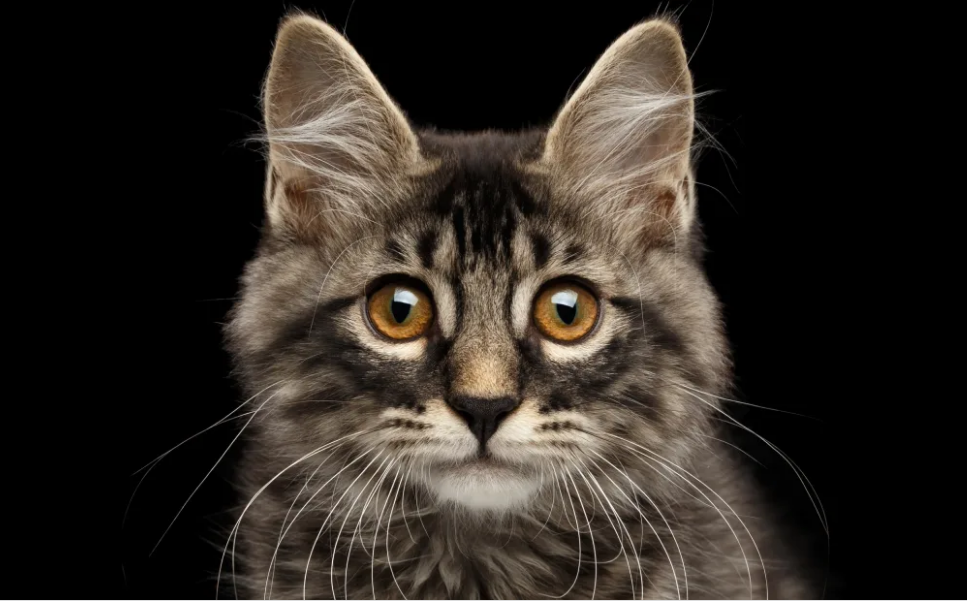
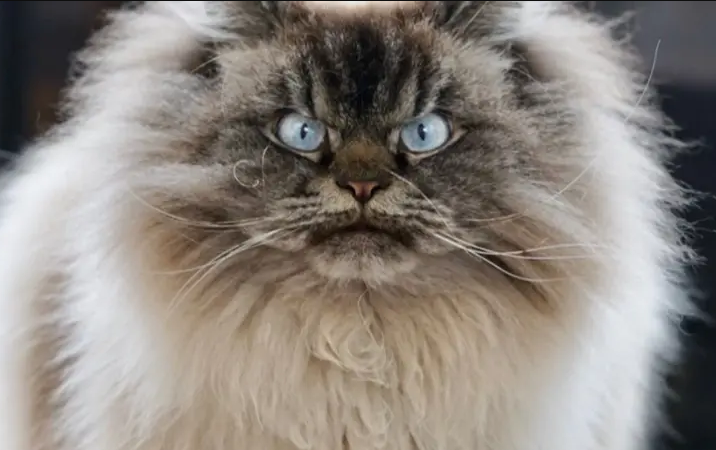
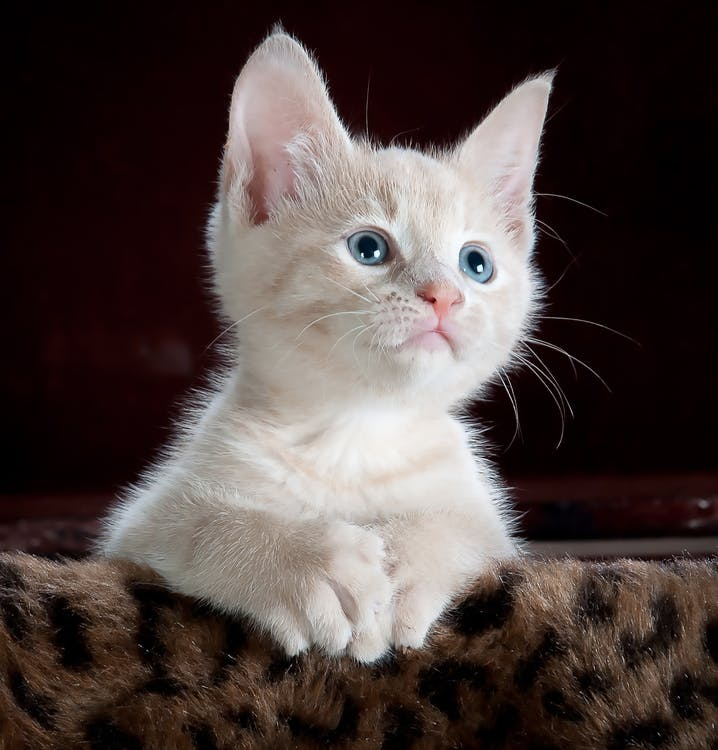
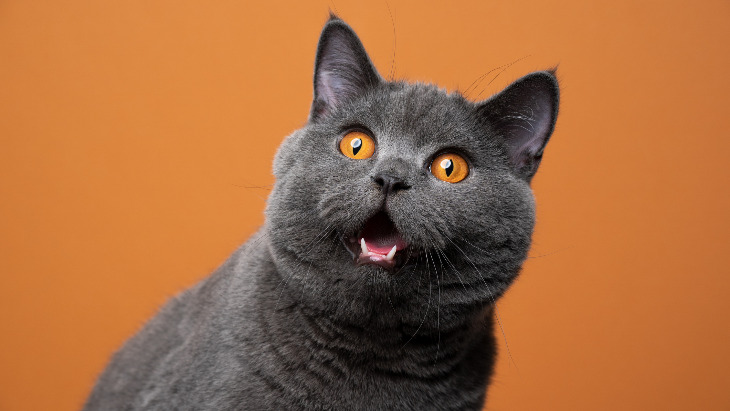
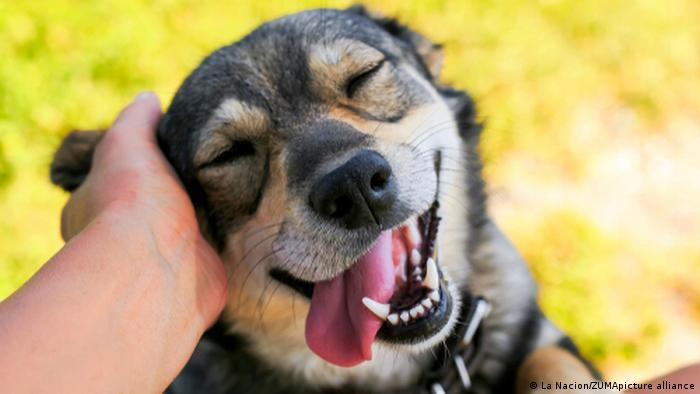
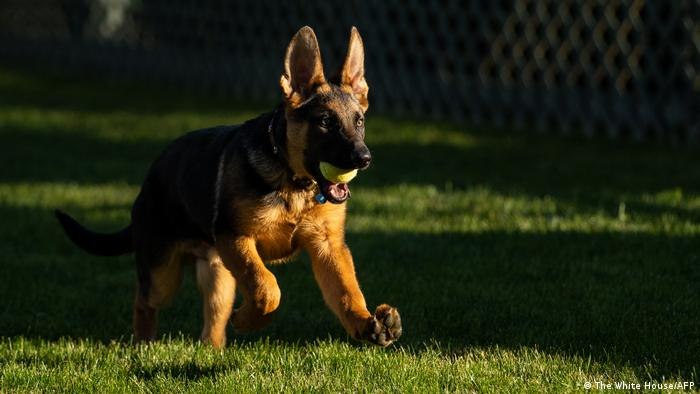
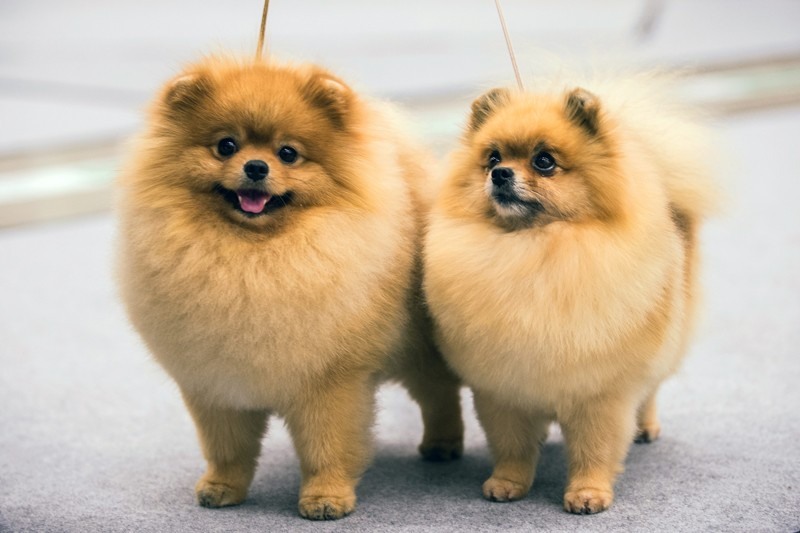
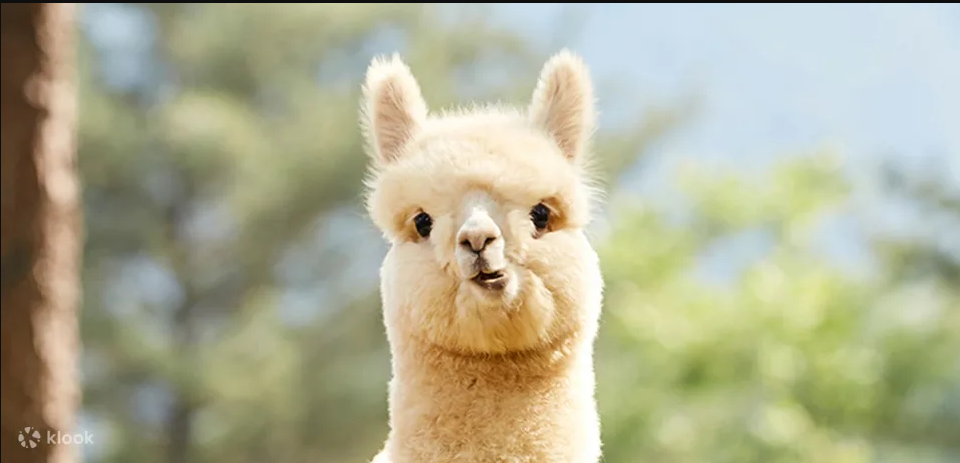
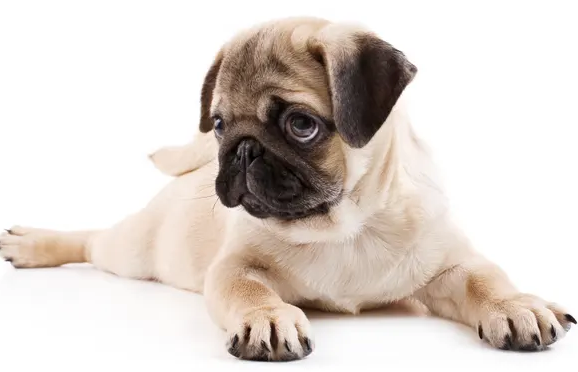

In [485]:
import os
import glob
import cv2
import pandas as pd
from IPython.display import HTML
from PIL import Image
from io import BytesIO
import base64


def encode_image_as_thumbnail(image_path, width=100):
    try:
        with open(image_path, "rb") as img_file:
            encoded_image = base64.b64encode(img_file.read()).decode("utf-8")
        return f'<img src="data:image/jpeg;base64,{encoded_image}" width="{width}"/>'
    except Exception as e:
        print(f"Failed to encode image {image_path}: {e}")
        return ""


def extract_image_metadata(image_path):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            return None

        file_name = os.path.basename(image_path)
        file_format = file_name.split('.')[-1].upper()
        
        channels = image.shape[2] if len(image.shape) == 3 else 1
        color_model = 'RGBA' if channels == 4 else ('RGB' if channels == 3 else 'Grayscale')
        
        file_size_mb = round(os.path.getsize(image_path) / (1024 * 1024), 2)
        height, width = image.shape[:2]
        full_path = os.path.abspath(image_path)

        return {
            "name": file_name,
            "color model": color_model,
            "format": file_format,
            "channels": channels,
            "size": file_size_mb,
            "width": width,
            "height": height,
            "full path": full_path,
            "image": image_path
        }

    except Exception as e:
        print(f"Error processing file {image_path}: {e}")
        return None


def generate_image_dataframe(folder_path):
    image_data = []

    for file_path in sorted(glob.glob(os.path.join(folder_path, "*"))):
        metadata = extract_image_metadata(file_path)
        if metadata:
            image_data.append(metadata)

    dataframe = pd.DataFrame(image_data)
    
    return dataframe


def display_images_as_dataframe(folder_path):
    dataframe = generate_image_dataframe(folder_path)
    
    return HTML(dataframe.to_html(escape=False, formatters={'image': encode_image_as_thumbnail}))


image_folder_path = "/home/nikita/python-data-processing/lab5/images"
html_output = display_images_as_dataframe(image_folder_path)
html_output

#### Task 2. Create a poster from the images in the folder using the OpenCV library

#### 1) Create a function that takes following arguments:
- the path to the folder;
- name of output image file;
- the number of images in a row;
- the number of images in a column
#### and returns the poster image.
#### We assume that the poster is rectangular and the number of pictures in the poster is a x b, where a is the number of columns and b is the number of rows.
#### 2) Create a function that converts the picture into a square with the maximum possible side size (for example, for the picture 800x533, the output size should be 533x533). We crop image on both sides, that is, we calculate the size from the image center.
#### 3) All pictures from which the poster is created must be of the same size, that is, after cropping, the size must be changed, for example, by 500x500.
#### 4) To add images to poster, pick them randomly. Pictures may be repeated.
#### 5) "Filter" the image with red, green, blue, yellow, magenta, or cyan colors, which are also randomly selected and may repeat.
#### 6) Provide 3-4 versions of posters saved in files on disk.

In [486]:
import os
import cv2
import glob
import numpy as np
import random

def crop_to_square(image):
    height, width = image.shape[:2]
    side_length = min(height, width)
    center_x, center_y = width // 2, height // 2
    x_start = center_x - side_length // 2
    y_start = center_y - side_length // 2
    
    return image[y_start:y_start + side_length, x_start:x_start + side_length]


def resize_image(image, size):
    return cv2.resize(image, (size, size))


def apply_random_filter(image):
    filters = {
        "red": np.array([0, 0, 1]),
        "green": np.array([0, 1, 0]),
        "blue": np.array([1, 0, 0]),
        "yellow": np.array([0, 1, 1]),
        "magenta": np.array([1, 0, 1]),
        "cyan": np.array([1, 1, 0]),
    }

    filter_name = random.choice(list(filters.keys()))
    filter_mask = filters[filter_name]

    return (image * filter_mask).astype(np.uint8)


def create_poster(folder_path, output_file, images_per_row, images_per_column, image_size=500):
    image_files = glob.glob(os.path.join(folder_path, "*"))
    if not image_files:
        raise ValueError(f"No images found in the folder: {folder_path}")

    total_images_needed = images_per_row * images_per_column

    poster_width = images_per_row * image_size
    poster_height = images_per_column * image_size
    poster = np.zeros((poster_height, poster_width, 3), dtype=np.uint8)

    for row in range(images_per_column):
        for col in range(images_per_row):
            image_path = random.choice(image_files)
            image = cv2.imread(image_path)

            if image is None:
                continue

            square_image = crop_to_square(image)
            resized_image = resize_image(square_image, image_size)
            filtered_image = apply_random_filter(resized_image)

            y_start = row * image_size
            x_start = col * image_size
            poster[y_start:y_start + image_size, x_start:x_start + image_size] = filtered_image

    cv2.imwrite(output_file, poster)
    
    return poster


def generate_multiple_posters(folder_path, output_dir, num_posters, images_per_row, images_per_column, image_size=500):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in range(num_posters):
        output_file = os.path.join(output_dir, f"poster_{i + 1}.jpg")
        create_poster(folder_path, output_file, images_per_row, images_per_column, image_size)

folder_path = "/home/nikita/python-data-processing/lab5/images"
output_dir = "/home/nikita/python-data-processing/lab5/posters"
num_posters = 4
images_per_row = 3
images_per_column = 2
image_size = 500

generate_multiple_posters(folder_path, output_dir, num_posters, images_per_row, images_per_column, image_size)

---

## 🏁 **Conclusion**

> Having completed this laboratory work, I got the hands-on experience in **digital image processing with OpenCV library and processing a bunch of digital images.**

---